In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

from config import DATASET_PATH
from datasets import (Dataset, RAVDESSLabel, TESSLabel, 
                     EMOVOLabel, SAVEELabel, MFCCData, WAVData,
                     RAVDESSUnifiedLabel, TESSUnifiedLabel, SAVEEUnifiedLabel,
                     EMOVOUnifiedLabel)

from tools import add_margin, IndexPicker

### Load Datasets

In [2]:
ravdess_path = DATASET_PATH.format(language="english", name="RAVDESS", form="mfcc")

ravdess_mfcc_unified = Dataset(ravdess_path, MFCCData(), RAVDESSUnifiedLabel())

In [3]:
tess_path = DATASET_PATH.format(language="english", name="TESS", form="mfcc")

tess_mfcc_unified = Dataset(tess_path, MFCCData(), TESSUnifiedLabel())

In [4]:
savee_path = DATASET_PATH.format(language="english", name="SAVEE", form="mfcc")

savee_mfcc_unified = Dataset(savee_path, MFCCData(), SAVEEUnifiedLabel())

In [5]:
emovo_path = DATASET_PATH.format(language="italian", name="EMOVO", form="mfcc")

emovo_mfcc_unified = Dataset(emovo_path, MFCCData(), EMOVOUnifiedLabel())

### Combine Datasets

In [6]:
ravdess_mfcc_unified.combine(savee_mfcc_unified, tess_mfcc_unified, emovo_mfcc_unified)

In [7]:
dataset = ravdess_mfcc_unified

In [8]:
samples = dataset.samples

In [9]:
X = np.array(list(samples['coefficients']))

y = np.array(list(samples['emotion']))

In [10]:
n_classes = len(np.unique(y))

In [11]:
y.shape

(1282163,)

In [12]:
X.shape

(1282163, 39)

### Add Margin

In [13]:
index_picker = IndexPicker(10, 10)
%time X_margined = np.array(add_margin(X, index_picker))

CPU times: user 11.1 s, sys: 3.88 s, total: 14.9 s
Wall time: 15 s


In [14]:
X_margined.shape

(1282163, 21, 39)

### Reshape

In [15]:
n_samples,window_length,n_features = X_margined.shape
%time X_reshaped = np.array(np.reshape(X_margined, (n_samples, -1)))

CPU times: user 2.33 s, sys: 1.44 s, total: 3.77 s
Wall time: 3.77 s


In [16]:
X_reshaped.shape

(1282163, 819)

## Modeling

In [17]:
from sklearn.base import TransformerMixin,BaseEstimator


class Scaler(BaseEstimator,TransformerMixin):

    def __init__(self, scaler):
        self.scaler = scaler

    def fit(self,X,y=None):
        self.scaler.fit(X.reshape(-1, 1))
        return self

    def transform(self,X):
        return self.scaler.transform(X.reshape(-1, 1)).reshape(X.shape)

### Prepere for model fitting

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

X_train_full, X_test, y_train_full, y_test = train_test_split(X_reshaped, y, stratify=y, test_size=0.05)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, stratify=y_train_full, test_size=0.05)

scaler = Scaler(StandardScaler())
%time X_train = scaler.fit_transform(X_train)    ## fit it only on train data
%time X_valid = scaler.transform(X_valid)
%time X_test = scaler.transform(X_test)

CPU times: user 15.3 s, sys: 14.4 s, total: 29.7 s
Wall time: 30.3 s
CPU times: user 216 ms, sys: 114 ms, total: 329 ms
Wall time: 320 ms
CPU times: user 249 ms, sys: 702 ms, total: 951 ms
Wall time: 1.51 s


### Create model

In [19]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(n_classes, activation="softmax"))

In [20]:
# model.summary()

### Compile Model

In [21]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])

### Fit Model

In [22]:
%time history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))

Epoch 1/30
36161/36161 [==============================] - 34s 944us/step - loss: 1.3855 - accuracy: 0.4712 - val_loss: 1.2314 - val_accuracy: 0.5325
Epoch 2/30
36161/36161 [==============================] - 35s 969us/step - loss: 1.1631 - accuracy: 0.5604 - val_loss: 1.1102 - val_accuracy: 0.5798
Epoch 3/30
36161/36161 [==============================] - 34s 953us/step - loss: 1.0769 - accuracy: 0.5939 - val_loss: 1.0576 - val_accuracy: 0.6014
Epoch 4/30
36161/36161 [==============================] - 33s 913us/step - loss: 1.0227 - accuracy: 0.6140 - val_loss: 1.0312 - val_accuracy: 0.6082
Epoch 5/30
36161/36161 [==============================] - 33s 918us/step - loss: 0.9840 - accuracy: 0.6284 - val_loss: 0.9724 - val_accuracy: 0.6340
Epoch 6/30
36161/36161 [==============================] - 33s 912us/step - loss: 0.9551 - accuracy: 0.6396 - val_loss: 0.9578 - val_accuracy: 0.6380
Epoch 7/30
36161/36161 [==============================] - 33s 919us/step - loss: 0.9319 - accuracy: 0.6486

### Plot History

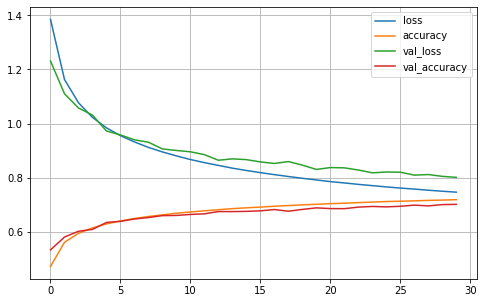

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
#plt.gca().set_ylim(0, 1)
plt.show()

### Evaluate Model

In [24]:
model.evaluate(X_test, y_test)

2004/2004 [==============================] - 1s 585us/step - loss: 0.8156 - accuracy: 0.6936


[0.8156483173370361, 0.6936155557632446]

In [27]:
# model.save('models/tensorflow_keras/ravdess_savee_tess_emovo--10_10--StandardScaler--300_relu-100_relu-10_softmax--scc_sgd_accuracy--30')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/tensorflow_keras/ravdess_savee_tess_emovo--10_10--StandardScaler--300_relu-100_relu-10_softmax--scc_sgd_accuracy--30/assets
